In [24]:
# push!(LOAD_PATH, normpath(@__DIR__, "../../", "src/models"));
# push!(LOAD_PATH, normpath(@__DIR__, "../../", "src/processing"));
# push!(LOAD_PATH, normpath(@__DIR__, "../../", "src/util"));
# ENV["COLUMNS"] = 200;

In [25]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions

include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [45]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI"]

start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)

pct_beds_available = 0.25
travel_threshold_hours = 4.0
hospitalized_days = 14;

In [46]:
N = length(states);
T = (end_date - start_date).value + 1;

In [47]:
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [48]:
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)[:];

In [49]:
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days));

In [50]:
beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available);
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [51]:
model = patient_redistribution(
    beds,
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    adj,
    Exponential(5)
)




Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21


A JuMP Model
Minimization problem with:
Variables: 10230
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 1860 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 930 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4092 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 6138 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: active_patients, overflow, sent

In [52]:
model = patient_redistribution(
    beds,
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    adj,
    Exponential(100),

    sent_penalty=0,
    smoothness_penalty=0,
    sendreceive_gap=0,
    min_send_amt=0,
    
    setup_cost=0,
    
    verbose=true,
)
sent = value.(model[:sent])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2790 rows, 10230 columns and 1568910 nonzeros
Model fingerprint: 0x2a104a2f
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 25 rows and 4101 columns
Presolve time: 0.45s
Presolved: 2765 rows, 6129 columns, 974603 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...


Barrier performed 0 iterations in 1.05 seconds (0.78 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1493    6.0849951e

In [53]:
results = PatientAllocationResults.results_all(sent, beds, forecast_initial, forecast_admitted, forecast_discharged, states, start_date, hospitalized_days);

In [54]:
println("Total overflow: ", results.total_overflow)
println("Average load: ", results.average_load)

Total overflow: 0.0
Average load: -362.5743


In [55]:
results.summary_table

Row,location,total_sent,total_received,overflow,overall_load,overflow_nosent,overall_load_nosent
,String,Float64,Float64,Float64,Float64,Float32,Float32
1,CT,1138.93,1438.78,0.0,-5.56434,0.0,-5.59563
2,DE,0.0,427.913,0.0,-1.75713,0.0,-1.88425
3,MA,202.8,3259.33,0.0,-2.38233,0.0,-2.49819
4,MD,461.5,1716.42,0.0,-4.28005,0.0,-4.36704
5,ME,36.5873,842.599,0.0,-0.181041,0.0,-0.359982
6,NH,135.425,566.314,0.0,-1.21153,0.0,-1.32628
7,NJ,1543.2,253.907,0.0,-6.83863,0.0,-6.79965
8,NY,12281.6,0.0,0.0,-5.08748,0.0,-4.92251
9,PA,0.0,6866.96,0.0,-1.66269,0.0,-1.79223


In [56]:
results.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,0.0,181.939,0.0,531.592,425.4,0.0,0.0,0.0,0.0
2,DE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MA,0.0,0.0,0.0,0.0,80.7198,122.08,0.0,0.0,0.0,0.0
4,MD,0.0,200.507,0.0,0.0,0.0,0.0,0.0,0.0,260.992,0.0
5,ME,0.0,0.0,36.5873,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NH,0.0,0.0,33.8471,0.0,93.0874,0.0,0.0,0.0,0.0,8.49011
7,NJ,37.3299,0.0,699.794,0.0,0.0,0.0,0.0,0.0,806.079,0.0
8,NY,1401.45,227.405,2307.17,1716.42,0.0,0.0,253.907,0.0,5799.89,575.342
9,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
println("First day:")
filter(row -> row.date == start_date, results.complete_table)

First day:


Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,CT,2020-03-30,106.573,0.0,3.70665,217.865,217.865,1840.25,0.0,0.118389,0.0,0.118389,"[(""NH"", 106.573)]",[]
2,DE,2020-03-30,0.0,0.0,0.0,20.7745,20.7745,506.75,0.0,0.0409956,0.0,0.0409956,[],[]
3,MA,2020-03-30,0.0,8.31923,4.0887,104.953,96.6341,3997.75,0.0,0.0262531,0.0,0.0241721,[],"[(""ME"", 4.07372), (""NH"", 4.24551)]"
4,MD,2020-03-30,0.0,0.0,0.0,133.496,133.496,2228.75,0.0,0.0598971,0.0,0.0598971,[],[]
5,ME,2020-03-30,4.07372,11.3683,0.0,24.2872,12.9188,668.0,0.0,0.036358,0.0,0.0193396,"[(""MA"", 4.07372)]","[(""RI"", 11.3683)]"
6,NH,2020-03-30,4.24551,106.573,0.0,123.535,16.9628,584.5,0.0,0.211352,0.0,0.029021,"[(""MA"", 4.24551)]","[(""CT"", 106.573)]"
7,NJ,2020-03-30,0.0,0.0,19.1623,1035.53,1035.53,4553.25,0.0,0.227427,0.0,0.227427,[],[]
8,NY,2020-03-30,0.0,0.0,117.661,4348.66,4348.66,10406.2,0.0,0.417889,0.0,0.41789,[],[]
9,PA,2020-03-30,0.0,0.0,3.7197,197.962,197.962,7980.25,0.0,0.0248065,0.0,0.0248065,[],[]


In [58]:
s = "NJ"
filter(row -> row.location == s, results.complete_table)

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,NJ,2020-03-30,0.0,0.0,19.1623,1035.53,1035.53,4553.25,0.0,0.227427,0.0,0.227427,[],[]
2,NJ,2020-03-31,0.0,0.0,27.2138,520.48,520.48,4553.25,0.0,0.11431,0.0,0.11431,[],[]
3,NJ,2020-04-01,0.0,0.0,34.3332,-54.9094,-54.9094,4553.25,0.0,-0.0120594,0.0,-0.0120594,[],[]
4,NJ,2020-04-02,0.0,253.907,45.6683,-432.555,-686.461,4553.25,0.0,-0.0949991,0.0,-0.150763,[],"[(""NY"", 253.907)]"
5,NJ,2020-04-03,699.794,0.0,61.6248,-1115.4,-1369.3,4553.25,0.0,-0.244967,0.0,-0.300731,"[(""MA"", 699.794)]",[]
6,NJ,2020-04-04,806.079,0.0,80.9276,-2540.34,-2094.46,4553.25,0.0,-0.557919,0.0,-0.459991,"[(""PA"", 806.079)]",[]
7,NJ,2020-04-05,37.3299,0.0,103.17,-4110.37,-2858.41,4553.25,0.0,-0.902734,0.0,-0.627773,"[(""CT"", 37.3299)]",[]
8,NJ,2020-04-06,0.0,0.0,131.107,-4936.69,-3647.39,4553.25,0.0,-1.08421,0.0,-0.801053,[],[]
9,NJ,2020-04-07,0.0,0.0,166.104,-5739.61,-4450.31,4553.25,0.0,-1.26055,0.0,-0.977392,[],[]


In [59]:
results.sent_to

Dict{String, Vector{String}} with 10 entries:
  "NH" => ["MA", "ME", "RI"]
  "CT" => ["MA", "ME", "NH"]
  "RI" => ["ME", "NH"]
  "MA" => ["ME", "NH"]
  "ME" => ["MA"]
  "NY" => ["CT", "DE", "MA", "MD", "NJ", "PA", "RI"]
  "NJ" => ["CT", "MA", "PA"]
  "DE" => []
  "PA" => []
  "MD" => ["DE", "PA"]

In [60]:
df = results.complete_table

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,CT,2020-03-30,106.573,0.0,3.70665,217.865,217.865,1840.25,0.0,0.118389,0.0,0.118389,"[(""NH"", 106.573)]",[]
2,CT,2020-03-31,125.098,0.0,7.5852,-6.22106,100.352,1840.25,0.0,-0.00338055,0.0,0.0545315,"[(""ME"", 125.098)]",[]
3,CT,2020-04-01,143.616,1394.83,7.63875,1127.54,-35.6259,1840.25,0.0,0.612709,0.0,-0.0193592,"[(""ME"", 143.616)]","[(""NY"", 1394.83)]"
4,CT,2020-04-02,162.209,6.62077,11.3346,839.668,-186.5,1840.25,0.0,0.456279,0.0,-0.101345,"[(""ME"", 162.209)]","[(""NY"", 6.62077)]"
5,CT,2020-04-03,181.939,0.0,15.0291,510.549,-353.41,1840.25,0.0,0.277435,0.0,-0.192045,"[(""MA"", 181.939)]",[]
6,CT,2020-04-04,204.368,0.0,19.0233,143.265,-538.755,1840.25,0.0,0.0778507,0.0,-0.292762,"[(""NH"", 204.368)]",[]
7,CT,2020-04-05,202.169,37.3299,22.6094,-223.714,-738.696,1840.25,0.0,-0.121567,0.0,-0.40141,"[(""ME"", 90.4857), (""NH"", 111.684)]","[(""NJ"", 37.3299)]"
8,CT,2020-04-06,0.0,0.0,29.8746,-642.026,-954.838,1840.25,0.0,-0.34888,0.0,-0.518863,[],[]
9,CT,2020-04-07,0.0,0.0,33.7842,-873.306,-1186.12,1840.25,0.0,-0.474558,0.0,-0.644542,[],[]


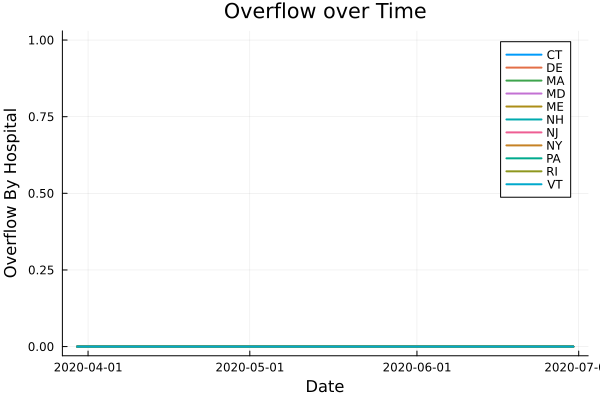

In [64]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Overflow=df.overflow)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
overflow_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    overflow_matrix[i, :] .= state_df.Overflow
end

# check the shortage matrix
#size(shortage_matrix)
using Plots
date_range = start_date:end_date
plot(date_range, [vec(overflow_matrix[i,:]) for i in 1:size(overflow_matrix)[1]],
     xlabel = "Date",
     ylabel = "Overflow By Hospital",
     title = "Overflow over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "PA_overflow_plot.png"))

In [67]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Patient Transfer By Hospital",
     title = "Total Patient Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "PA_PSent_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/PA_PSent_plot.png"